In [1]:
## Parameters specific to where your folders are and your data
parameter_file = '../params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']
mRNA_peak_file = doc["mRNA_peak_file"]

tss_annotation = doc['tss_annotation']

import tqdm
import os
from os.path import join
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
from tqdm import *
from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *
import helper
import create_output
print('Number of tissues: ',len(tissues))

from collections import Counter


/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


Number of tissues:  13


In [2]:
# import os
# import sys
# import pandas as pd
# import matplotlib
# import seaborn as sns
# import pickle
# import numpy as np
# import matplotlib as mpl
# from matplotlib import pyplot as plt
# from itertools import product
# import glob
# import re
# from matplotlib_venn import venn2
# from matplotlib import rcParams
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
# sys.setrecursionlimit(3000)
# sns.set_context('notebook')
# %load_ext autoreload
# %autoreload 2
# rcParams['figure.figsize'] = 8, 6
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Tahoma']
# import tqdm
# ### notebook specific configuration ###
# from os.path import basename
# mpl.style.use('fivethirtyeight')

In [3]:
from os.path import join

In [4]:
from Homer import *

## Input Files

In [5]:
genome_raw_dir = os.path.join(doc["supplemental"], "genome", "ncbi_anno_103")
ref_fa = os.path.join(genome_raw_dir,'GCF_003668045.1_CriGri-PICR_genomic.fna')
annotation = os.path.join(genome_raw_dir,'alt_CriGri-PICR_top_level.gff3')
                      

## Output files

In [6]:
genome_dir = "Results/genome/"
if not os.path.exists(genome_dir):
    os.mkdir(genome_dir)

In [7]:
ref_start_f = join(genome_dir,'start_site_mRNA.tsv')
mrna_peak = join(genome_dir,'mRNA.peak')
exon_peak = join(genome_dir,'exon.peak')
cds_peak = join(genome_dir,'CDS.peak')

cds_bed = join(genome_dir, 'CDS.bed')
mrna_bed = join(genome_dir,'mRNA.bed')
cds_gff = join(genome_dir, 'CDS.gff')
mrna_gff = join(genome_dir, 'mRNA.gff')

all_genes_f = join(genome_dir,"all_genes.tsv")
ref_start_homer_f= join(genome_dir,'start_site_mRNA_homer.tsv')

### Create a mock peak file of the RefSeq mRNA and exons to be used later

In [8]:
createPeakFileFromGFF(
    annotation,
    output_file=mrna_peak,
    anno_of_interest='mRNA',
    is_start=True)

createPeakFileFromGFF(
    annotation,
    output_file=exon_peak,
    anno_of_interest='exon',
    is_start=True)

createPeakFileFromGFF(
    annotation,
    output_file=cds_peak,
    anno_of_interest='CDS',
    is_start=True)

### Read in mrna_peak and separate the gene information

In [9]:
mrna_peak_df = pd.read_csv(mrna_peak,sep="\t",index_col=0)

for ind in mrna_peak_df.index.values:
    curr = ind.split(';')
    for i in curr:
        curr_split = i.split('=')
        mrna_peak_df.set_value(ind,curr_split[0],curr_split[1])

mrna_peak_df.set_index("transcript_id",inplace=True)
mrna_peak_df.index.drop_duplicates() #There is one duplicate transcript
mrna_peak_df.to_csv(mrna_peak,sep="\t",index="transcript_id")

mrna_peak_df.head()

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


,Chr,Start,End,Strand,actual_start,ID,Parent,Dbxref,Name,gbkey,gene,model_evidence,product,Note,exception,end_range,partial,start_range,inference
transcript_id,,,,,,,,,,,,,,,,,,,
XM_027386529.1,NW_020822366.1,722307,722309,-,722309,rna7,gene4,"GeneID:100754303,Genbank:XM_027386529.1",XM_027386529.1,mRNA,Bmp4,Supporting evidence includes similarity to: 29...,bone morphogenetic protein 4%2C transcript var...,NaN,NaN,NaN,NaN,NaN,NaN
XM_027386530.1,NW_020822366.1,722307,722309,-,722309,rna8,gene4,"GeneID:100754303,Genbank:XM_027386530.1",XM_027386530.1,mRNA,Bmp4,Supporting evidence includes similarity to: 29...,bone morphogenetic protein 4%2C transcript var...,NaN,NaN,NaN,NaN,NaN,NaN
XM_027386528.1,NW_020822366.1,724609,724611,-,724611,rna6,gene4,"GeneID:100754303,Genbank:XM_027386528.1",XM_027386528.1,mRNA,Bmp4,Supporting evidence includes similarity to: 29...,bone morphogenetic protein 4%2C transcript var...,NaN,NaN,NaN,NaN,NaN,NaN
XM_027386531.1,NW_020822366.1,1085434,1085436,+,1085434,rna10,gene6,"GeneID:100752216,Genbank:XM_027386531.1",XM_027386531.1,mRNA,Cdkn3,Supporting evidence includes similarity to: 5 ...,cyclin dependent kinase inhibitor 3%2C transcr...,NaN,NaN,NaN,NaN,NaN,NaN
XM_027386532.1,NW_020822366.1,1085434,1085436,+,1085434,rna11,gene6,"GeneID:100752216,Genbank:XM_027386532.1",XM_027386532.1,mRNA,Cdkn3,Supporting evidence includes similarity to: 2 ...,cyclin dependent kinase inhibitor 3%2C transcr...,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
mrna_peak_150 = './mRNA_150.peak'
createPeakFileFromGFF(
    annotation,
    output_file=mrna_peak_150,
    anno_of_interest='mRNA',
    is_start=True,
    shift=75)


In [11]:
mrna_peak_150_df = pd.read_csv(mrna_peak_150,sep="\t",index_col=0)

for ind in mrna_peak_150_df.index.values:
    curr = ind.split(';')
    for i in curr:
        curr_split = i.split('=')
        mrna_peak_150_df.set_value(ind,curr_split[0],curr_split[1])
mrna_peak_150_df.set_index("transcript_id",inplace=True)
mrna_peak_150_df.to_csv(mrna_peak_150,sep="\t",index="transcript_id")

mrna_peak_150_df.head()

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


,Chr,Start,End,Strand,actual_start,ID,Parent,Dbxref,Name,gbkey,gene,model_evidence,product,Note,exception,end_range,partial,start_range,inference
transcript_id,,,,,,,,,,,,,,,,,,,
XM_027386529.1,NW_020822366.1,722233,722383,-,722383,rna7,gene4,"GeneID:100754303,Genbank:XM_027386529.1",XM_027386529.1,mRNA,Bmp4,Supporting evidence includes similarity to: 29...,bone morphogenetic protein 4%2C transcript var...,NaN,NaN,NaN,NaN,NaN,NaN
XM_027386530.1,NW_020822366.1,722233,722383,-,722383,rna8,gene4,"GeneID:100754303,Genbank:XM_027386530.1",XM_027386530.1,mRNA,Bmp4,Supporting evidence includes similarity to: 29...,bone morphogenetic protein 4%2C transcript var...,NaN,NaN,NaN,NaN,NaN,NaN
XM_027386528.1,NW_020822366.1,724535,724685,-,724685,rna6,gene4,"GeneID:100754303,Genbank:XM_027386528.1",XM_027386528.1,mRNA,Bmp4,Supporting evidence includes similarity to: 29...,bone morphogenetic protein 4%2C transcript var...,NaN,NaN,NaN,NaN,NaN,NaN
XM_027386531.1,NW_020822366.1,1085360,1085510,+,1085360,rna10,gene6,"GeneID:100752216,Genbank:XM_027386531.1",XM_027386531.1,mRNA,Cdkn3,Supporting evidence includes similarity to: 5 ...,cyclin dependent kinase inhibitor 3%2C transcr...,NaN,NaN,NaN,NaN,NaN,NaN
XM_027386532.1,NW_020822366.1,1085360,1085510,+,1085360,rna11,gene6,"GeneID:100752216,Genbank:XM_027386532.1",XM_027386532.1,mRNA,Cdkn3,Supporting evidence includes similarity to: 2 ...,cyclin dependent kinase inhibitor 3%2C transcr...,NaN,NaN,NaN,NaN,NaN,NaN


### First take the mRNA and CDS separately. 

### Create CDS and mRNA gff and bed file

In [12]:
cmd = "awk '{ if ($3==\"mRNA\") {print}  }' %s > %s" % (annotation,mrna_gff)
print(cmd)
!{cmd}

awk '{ if ($3=="mRNA") {print}  }' /data/isshamie/TSS/Analysis/supplemental/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 > Results/genome/mRNA.gff


In [13]:
cmd = "awk '{ if ($3==\"CDS\") {print}  }' %s > %s" % (annotation,cds_gff)
print(cmd)
!{cmd}

awk '{ if ($3=="CDS") {print}  }' /data/isshamie/TSS/Analysis/supplemental/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 > Results/genome/CDS.gff


In [14]:
cmd = "gff2bed < {cds_gff} > {cds_bed}".format(cds_gff= cds_gff, cds_bed=cds_bed)
print(cmd)
os.system(cmd)

gff2bed < Results/genome/CDS.gff > Results/genome/CDS.bed


0

In [15]:
cmd = "gff2bed < {mrna_gff} > {mrna_bed}".format(mrna_gff= mrna_gff, mrna_bed=mrna_bed)
print(cmd)
os.system(cmd)

gff2bed < Results/genome/mRNA.gff > Results/genome/mRNA.bed


0

--------------------

# Construct start site specific file
'ID','Chr','Start','End','Strand','CS','gene_id','gene','transcript_id' 
If two transcripts have the same start site, pick the one with lower cs (more confident), if the same cs, pick the longer TS

### Read in annotation

In [16]:
mRNA_anno = pd.read_csv(mrna_gff,sep='\t',header=None,index_col=8)
#Munge data for downstream processing
cols = mRNA_anno.columns.values
cols = ['Chr','Merge','Type','Start','End','.','Strand','..']
mRNA_anno.columns= cols
#Drop the unncesseary columns
mRNA_anno.drop(['Merge','.','..','Type'],axis=1,inplace=True)
mRNA_anno.head()

,Chr,Start,End,Strand
8,,,,
"ID=rna6;Parent=gene4;Dbxref=GeneID:100754303,Genbank:XM_027386528.1;Name=XM_027386528.1;gbkey=mRNA;gene=Bmp4;model_evidence=Supporting evidence includes similarity to: 29 Proteins%2C and 100%25 coverage of the annotated genomic feature by RNAseq alignments%2C including 18 samples with support for all annotated introns;product=bone morphogenetic protein 4%2C transcript variant X2;transcript_id=XM_027386528.1",NW_020822366.1,717871,724610,-
"ID=rna7;Parent=gene4;Dbxref=GeneID:100754303,Genbank:XM_027386529.1;Name=XM_027386529.1;gbkey=mRNA;gene=Bmp4;model_evidence=Supporting evidence includes similarity to: 29 Proteins%2C and 100%25 coverage of the annotated genomic feature by RNAseq alignments%2C including 15 samples with support for all annotated introns;product=bone morphogenetic protein 4%2C transcript variant X3;transcript_id=XM_027386529.1",NW_020822366.1,717871,722308,-
"ID=rna8;Parent=gene4;Dbxref=GeneID:100754303,Genbank:XM_027386530.1;Name=XM_027386530.1;gbkey=mRNA;gene=Bmp4;model_evidence=Supporting evidence includes similarity to: 29 Proteins%2C and 100%25 coverage of the annotated genomic feature by RNAseq alignments%2C including 11 samples with support for all annotated introns;product=bone morphogenetic protein 4%2C transcript variant X4;transcript_id=XM_027386530.1",NW_020822366.1,717871,722308,-
"ID=rna10;Parent=gene6;Dbxref=GeneID:100752216,Genbank:XM_027386531.1;Name=XM_027386531.1;gbkey=mRNA;gene=Cdkn3;model_evidence=Supporting evidence includes similarity to: 5 Proteins%2C and 100%25 coverage of the annotated genomic feature by RNAseq alignments%2C including 98 samples with support for all annotated introns;product=cyclin dependent kinase inhibitor 3%2C transcript variant X1;transcript_id=XM_027386531.1",NW_020822366.1,1085435,1097417,+
"ID=rna11;Parent=gene6;Dbxref=GeneID:100752216,Genbank:XM_027386532.1;Name=XM_027386532.1;gbkey=mRNA;gene=Cdkn3;model_evidence=Supporting evidence includes similarity to: 2 Proteins%2C and 100%25 coverage of the annotated genomic feature by RNAseq alignments%2C including 98 samples with support for all annotated introns;product=cyclin dependent kinase inhibitor 3%2C transcript variant X2;transcript_id=XM_027386532.1",NW_020822366.1,1085435,1097417,+


### Break the annotation id into its separate components and calculate distances

In [17]:
for ind in mRNA_anno.index.values:
    curr = ind.split(';')
    for i in curr:
        curr_split = i.split('=')
        mRNA_anno.set_value(ind,curr_split[0],curr_split[1])

mRNA_anno['Length'] = mRNA_anno['End'] - mRNA_anno['Start']

### Need to create an extra column for tss called 'actual_start'. 
### This is to take care of issue of a gene starting at the End when it's on the minus strand
mRNA_anno['actual_start'] = mRNA_anno.apply( lambda x: x['Start'] if x['Strand'] == '+' else x['End'],axis=1)

mRNA_anno.head()

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


,Chr,Start,End,Strand,ID,Parent,Dbxref,Name,gbkey,gene,...,product,transcript_id,Note,exception,end_range,partial,start_range,inference,Length,actual_start
8,,,,,,,,,,,,,,,,,,,,,
"ID=rna6;Parent=gene4;Dbxref=GeneID:100754303,Genbank:XM_027386528.1;Name=XM_027386528.1;gbkey=mRNA;gene=Bmp4;model_evidence=Supporting evidence includes similarity to: 29 Proteins%2C and 100%25 coverage of the annotated genomic feature by RNAseq alignments%2C including 18 samples with support for all annotated introns;product=bone morphogenetic protein 4%2C transcript variant X2;transcript_id=XM_027386528.1",NW_020822366.1,717871,724610,-,rna6,gene4,"GeneID:100754303,Genbank:XM_027386528.1",XM_027386528.1,mRNA,Bmp4,...,bone morphogenetic protein 4%2C transcript var...,XM_027386528.1,NaN,NaN,NaN,NaN,NaN,NaN,6739,724610
"ID=rna7;Parent=gene4;Dbxref=GeneID:100754303,Genbank:XM_027386529.1;Name=XM_027386529.1;gbkey=mRNA;gene=Bmp4;model_evidence=Supporting evidence includes similarity to: 29 Proteins%2C and 100%25 coverage of the annotated genomic feature by RNAseq alignments%2C including 15 samples with support for all annotated introns;product=bone morphogenetic protein 4%2C transcript variant X3;transcript_id=XM_027386529.1",NW_020822366.1,717871,722308,-,rna7,gene4,"GeneID:100754303,Genbank:XM_027386529.1",XM_027386529.1,mRNA,Bmp4,...,bone morphogenetic protein 4%2C transcript var...,XM_027386529.1,NaN,NaN,NaN,NaN,NaN,NaN,4437,722308
"ID=rna8;Parent=gene4;Dbxref=GeneID:100754303,Genbank:XM_027386530.1;Name=XM_027386530.1;gbkey=mRNA;gene=Bmp4;model_evidence=Supporting evidence includes similarity to: 29 Proteins%2C and 100%25 coverage of the annotated genomic feature by RNAseq alignments%2C including 11 samples with support for all annotated introns;product=bone morphogenetic protein 4%2C transcript variant X4;transcript_id=XM_027386530.1",NW_020822366.1,717871,722308,-,rna8,gene4,"GeneID:100754303,Genbank:XM_027386530.1",XM_027386530.1,mRNA,Bmp4,...,bone morphogenetic protein 4%2C transcript var...,XM_027386530.1,NaN,NaN,NaN,NaN,NaN,NaN,4437,722308
"ID=rna10;Parent=gene6;Dbxref=GeneID:100752216,Genbank:XM_027386531.1;Name=XM_027386531.1;gbkey=mRNA;gene=Cdkn3;model_evidence=Supporting evidence includes similarity to: 5 Proteins%2C and 100%25 coverage of the annotated genomic feature by RNAseq alignments%2C including 98 samples with support for all annotated introns;product=cyclin dependent kinase inhibitor 3%2C transcript variant X1;transcript_id=XM_027386531.1",NW_020822366.1,1085435,1097417,+,rna10,gene6,"GeneID:100752216,Genbank:XM_027386531.1",XM_027386531.1,mRNA,Cdkn3,...,cyclin dependent kinase inhibitor 3%2C transcr...,XM_027386531.1,NaN,NaN,NaN,NaN,NaN,NaN,11982,1085435
"ID=rna11;Parent=gene6;Dbxref=GeneID:100752216,Genbank:XM_027386532.1;Name=XM_027386532.1;gbkey=mRNA;gene=Cdkn3;model_evidence=Supporting evidence includes similarity to: 2 Proteins%2C and 100%25 coverage of the annotated genomic feature by RNAseq alignments%2C including 98 samples with support for all annotated introns;product=cyclin dependent kinase inhibitor 3%2C transcript variant X2;transcript_id=XM_027386532.1",NW_020822366.1,1085435,1097417,+,rna11,gene6,"GeneID:100752216,Genbank:XM_027386532.1",XM_027386532.1,mRNA,Cdkn3,...,cyclin dependent kinase inhibitor 3%2C transcr...,XM_027386532.1,NaN,NaN,NaN,NaN,NaN,NaN,11982,1085435


### For each gene, collapse onto the unique start site so there is no double counting of isoforms that share a start site

In [24]:
%%time
annotation_start_site = pd.DataFrame(columns=mRNA_anno.columns.values)
for group,start_site in tqdm(mRNA_anno.groupby(['actual_start','Chr','gene'])):
    if len(start_site) == 1:
        annotation_start_site = annotation_start_site.append(start_site)
    else:
        #Pick the most confident txn and the longest transcript
        annotation_start_site = annotation_start_site.append(start_site.sort_values(['Length'],ascending=[False]).iloc[0])
annotation_start_site.sort_values(['Chr','Start'],inplace=True)

annotation_start_site['Start'] = annotation_start_site['Start'].astype(int)
annotation_start_site['End'] = annotation_start_site['End'].astype(int)

100%|██████████| 35680/35680 [13:05<00:00, 45.44it/s] 


CPU times: user 13min 7s, sys: 2.5 s, total: 13min 9s
Wall time: 13min 5s


### Save the start site data

In [25]:
annotation_start_site.to_csv(ref_start_f,sep='\t')

In [ ]:
### Need to create an extra column for tss called 'actual_start'. 
### This is to take care of issue of a gene starting at the End when it's on the minus strand
annotation_start_site['actual_start'] = annotation_start_site.apply( lambda x: x['Start'] if x['Strand'] == '+' else x['End'],axis=1)

## Create chrom.sizes , a tab delimited file with the first column being the chromosome name and the second the size

In [26]:
cmd = "samtools faidx {ref_fa}".format(ref_fa=ref_fa)
os.system(cmd)
print(cmd)
cmd = "cut -f1,2 {ref_fa_ind} > {chrom}".format(ref_fa_ind=ref_fa + ".fai" , chrom=join(genome_dir,"chrom.sizes"))
print(cmd)
os.system(cmd)

samtools faidx /data/isshamie/TSS/Analysis/supplemental/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna
cut -f1,2 /data/isshamie/TSS/Analysis/supplemental/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna.fai > Results/genome/chrom.sizes


0

## Save all_genes.tsv , which is just a text file with each row being the gene name

In [27]:
with open(all_genes_f,'w') as f:
    genes = list(pd.read_csv(mrna_peak,sep="\t").groupby("gene").groups.keys())
    genes.sort()
    f.write("\n".join(genes))
    

## Save in form of Homer peak file

In [28]:
annotation_start_site_homer = pd.read_csv(ref_start_f,sep='\t',index_col=0)

annotation_start_site_homer = annotation_start_site_homer[['Chr','Start','End','Strand','model_evidence']]
cols = ['chr','start','end','strand','Normalized Tag Count']
annotation_start_site_homer.columns = cols

annotation_start_site_homer.head()
annotation_start_site_homer.to_csv(ref_start_homer_f,sep='\t')

In [29]:
print(annotation_start_site.shape)
print(mRNA_anno.shape)

(35680, 21)
(46751, 21)


# Descriptives

In [30]:
genome_ann_mrna = pd.read_csv(mrna_peak,sep='\t',index_col=0)

genome_ann_exon = pd.read_csv(exon_peak,sep='\t',index_col=0)

#### Number of unique gene_names
print('Number of unique genes: ',len(set(genome_ann_mrna["gene"])))
#### Number of unique start sites for mrna
ss = set()
for ind, val in genome_ann_mrna.iterrows():
    ss.add(str(val['Start']) + '_' + val['Strand']+ '_' + val['Chr'])
print('Number of unique start sites for mrna', len(ss))

#print('Number of transcripts per gene: ',1.0*len(genome_ann_mrna)/len(unique_genes))

print('Number of transcripts',len(genome_ann_mrna))
print ('Number of exons',len(genome_ann_exon))



Number of unique genes:  21387
Number of unique start sites for mrna 35679
Number of transcripts 46751
Number of exons 630390


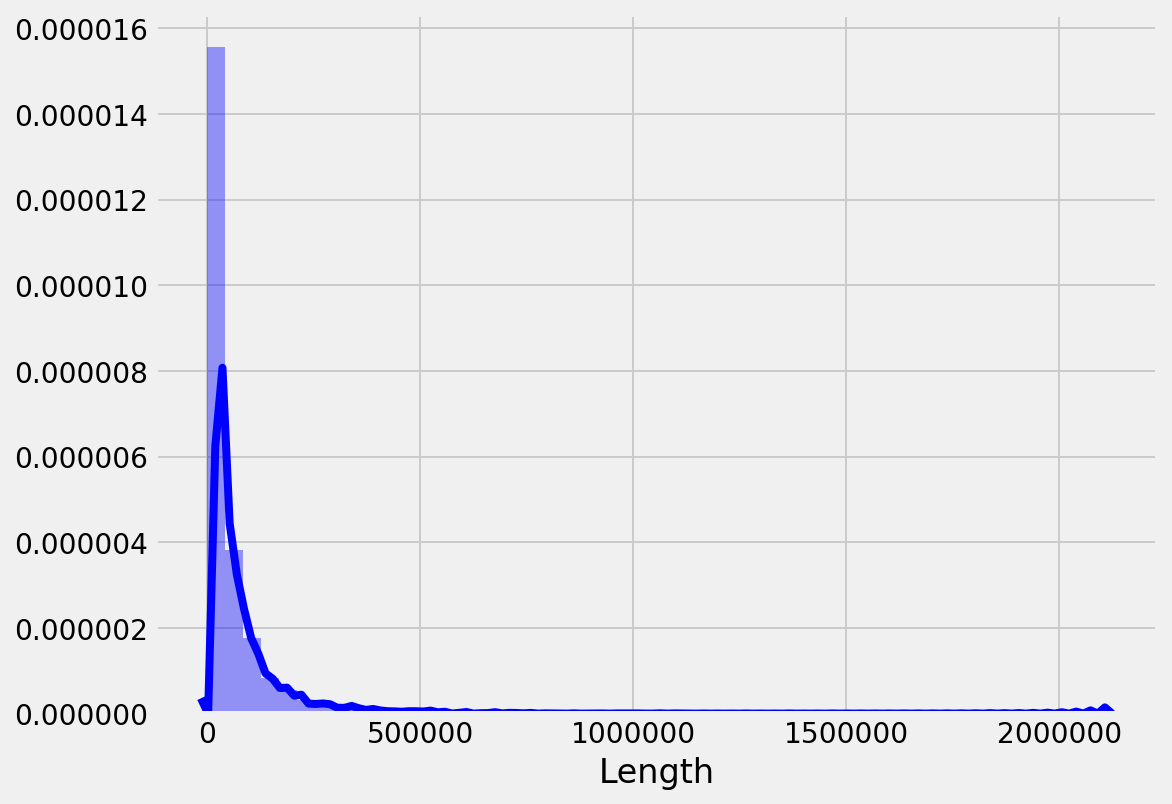

In [31]:
sns.distplot(mRNA_anno['Length'])

## Calculate distances between genes

In [32]:
distances = []
for gr,curr in annotation_start_site.groupby(['Chr','Strand']):
    if len(curr) > 1:
        for i in range(1,curr.shape[0]):
            distances.append(curr.iloc[i]['Start']-curr.iloc[i-1]['Start'])
distances = np.array(distances)

Text(0.5, 0, 'Log distance between genes')

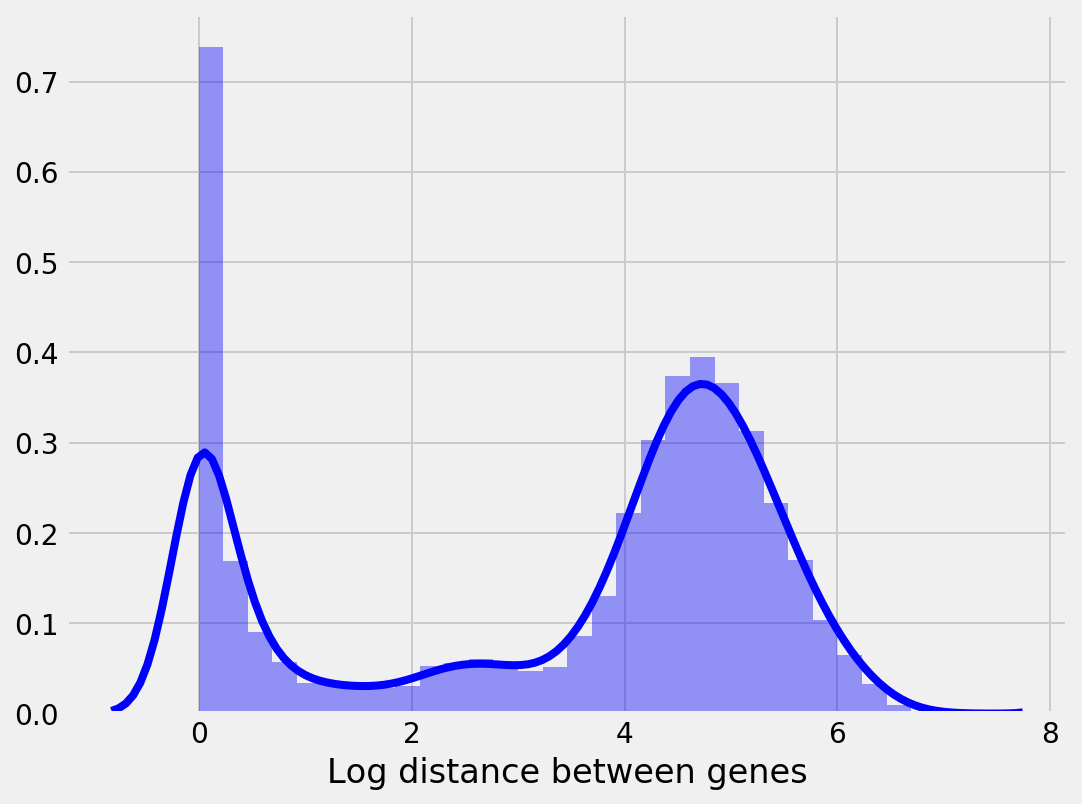

In [35]:
sns.distplot((np.log10(distances+1)))
plt.xlabel('Log distance between genes')

In [37]:
print('Number of start sites: ', len(distances))
print('Start sites on same bp: ' , np.sum(distances == 0))
print('Start sites less than 10 bp: ' , np.sum(distances < 10))
print('Start sites less than 100 bp: ' , np.sum(distances < 100))
print('Start sites less than 500 bp: ' , np.sum(distances < 500))
print('Start sites less than 500 bp: ' , np.sum(distances < 1000))

Number of start sites:  34744
Start sites on same bp:  5918
Start sites less than 10 bp:  8577
Start sites less than 100 bp:  9590
Start sites less than 500 bp:  10881
Start sites less than 500 bp:  11468


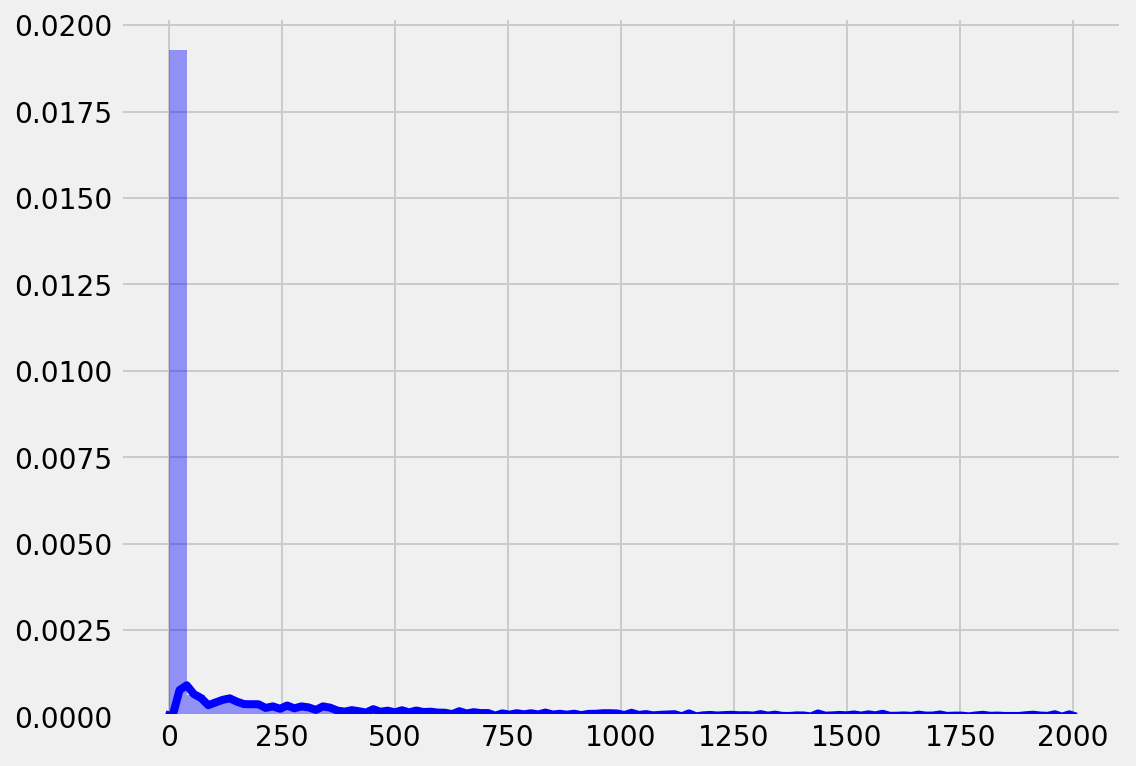

In [38]:
sns.distplot(distances[distances<2000],norm_hist=False)